In [1]:
import os
import numpy as np
import pandas
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DATA_PATH = '/Users/zhaoyu/Dropbox/AI-II-8750/Project/Data/'
PROJECT_PATH = '/Users/zhaoyu/Dropbox/AI-II-8750/Project/'

Using TensorFlow backend.


In [2]:
# read the train and test data
# resize the image to 128 by 128

train = pandas.read_csv(DATA_PATH + '/train.csv')
test = pandas.read_csv(DATA_PATH + '/test.csv')

# get the pre-extracted features
feat_train = train.copy()
feat_test = test.copy()
feat_train = feat_train.drop(['id', 'species'], axis=1)
feat_test = feat_test.drop(['id'], axis=1)
feat_train = StandardScaler().fit(feat_train).transform(feat_train)
feat_test = StandardScaler().fit(feat_test).transform(feat_test)

In [49]:
# Data augmentation
# image_data contains ALL images from the images folder

# method 1: resize directly
# image_data = {}
# for img_file in os.listdir(DATA_PATH + '/images'):
#     resized_img = imresize(imread(DATA_PATH + '/images/' + img_file), (256,256)).astype(np.float32)
#     image_data[img_file.split(".")[0]] = resized_img

# method 2: pad first, then resize
image_data = {}
for img_file in os.listdir(DATA_PATH + '/images'):
    img = imread(DATA_PATH + '/images/' + img_file)
    h, w = img.shape
    max_dim = max(h, w)
    padded_img = np.lib.pad(img, 
                     (((max_dim-h)//2, max_dim-h-(max_dim-h)//2), ((max_dim-w)//2, max_dim-w-(max_dim-w)//2)), 
                     'constant', constant_values=1)
    resized_img = imresize(padded_img, (128, 128)).astype(np.float32)
    image_data[img_file.split(".")[0]] = resized_img

In [50]:
print(train.shape)
print(feat_train.shape)
print(test.shape)
print(feat_test.shape)
print(len(image_data))

(990, 194)
(990, 192)
(594, 193)
(594, 192)
1584


In [51]:
# for key, value in image_data.items() :
#     print (key, value)
#     exit()

(128, 128)


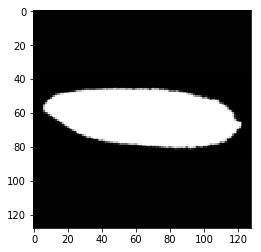

In [52]:
plt.imshow(image_data['2'], cmap='gray')
print(image_data['1'].shape)
plt.show()

In [53]:
# get labels
le = LabelEncoder()
le.fit(train.species)
print(le.classes_)
print(len(le.classes_))

['Acer_Capillipes' 'Acer_Circinatum' 'Acer_Mono' 'Acer_Opalus'
 'Acer_Palmatum' 'Acer_Pictum' 'Acer_Platanoids' 'Acer_Rubrum'
 'Acer_Rufinerve' 'Acer_Saccharinum' 'Alnus_Cordata' 'Alnus_Maximowiczii'
 'Alnus_Rubra' 'Alnus_Sieboldiana' 'Alnus_Viridis' 'Arundinaria_Simonii'
 'Betula_Austrosinensis' 'Betula_Pendula' 'Callicarpa_Bodinieri'
 'Castanea_Sativa' 'Celtis_Koraiensis' 'Cercis_Siliquastrum'
 'Cornus_Chinensis' 'Cornus_Controversa' 'Cornus_Macrophylla'
 'Cotinus_Coggygria' 'Crataegus_Monogyna' 'Cytisus_Battandieri'
 'Eucalyptus_Glaucescens' 'Eucalyptus_Neglecta' 'Eucalyptus_Urnigera'
 'Fagus_Sylvatica' 'Ginkgo_Biloba' 'Ilex_Aquifolium' 'Ilex_Cornuta'
 'Liquidambar_Styraciflua' 'Liriodendron_Tulipifera'
 'Lithocarpus_Cleistocarpus' 'Lithocarpus_Edulis' 'Magnolia_Heptapeta'
 'Magnolia_Salicifolia' 'Morus_Nigra' 'Olea_Europaea' 'Phildelphus'
 'Populus_Adenopoda' 'Populus_Grandidentata' 'Populus_Nigra' 'Prunus_Avium'
 'Prunus_X_Shmittii' 'Pterocarya_Stenoptera' 'Quercus_Afares'
 'Querc

In [54]:
train_labels = le.transform(train.species)
print(train_labels)
print(len(train_labels))

[ 3 49 65 94 84 40 54 78 53 89 98 16 74 50 58 31 43  4 75 44 83 84 13 66 15
  6 73 22 73 31 36 27 94 88 12 28 21 25 20 60 84 65 69 58 23 76 18 52 54  9
 48 47 64 81 83 36 58 21 81 20 62 88 34 92 79 82 20 32  4 84 36 35 72 60 71
 72 52 50 54 11 51 18 47  5  8 37 97 20 33  1 59  1 56  1  9 57 20 79 29 16
 32 54 93 10 46 59 84 76 15 10 15  0 69  4 51 51 94 36 39 62  2 24 26 35 25
 87  0 55 34 38  1 45  7 93 56 38 21 51 75 81 74 33 20 37  9 40 60 31 83 50
 71 67 30 66  1 43 61 23 65 84 87 46 57 16  2 28 12 96 44 76 29 75 41 87 67
 61 30  5 12 62  3 83 81  6 85  4 37 57 84 39 71 61  6 76 14 31 98 40 17 51
 16 42 63 86 37 69 86 71 80 78 14 35 25  5 39  8  9 26 44 60 13 14 77 13 80
 87 18 60 78 92 51 45 78 41 51 30 14 35 46 21  8  6 92 38 40 15 32 17 93 71
 92 27 78 15 19 60 21 38 36 49 74 67 95 31 82 45 16 83 63 80 42 22 74 53 15
 44 47 57 94 76 17 32 24 15 93 24 80 59 46 12 51 77 79 70 69 16  2 63 83 55
 12 53  1 67  0  2 36 42 10  9 52 59  6 22 86 31 51 37 43 75 90 24 86 96 45
 32 98 36 66

In [55]:
# separate train and test from image_data
image_train = np.array([image_data[str(idx)] for idx in train.id])
image_test = np.array([image_data[str(idx)] for idx in test.id])
image_train = np.expand_dims(image_train, axis=4)
image_test = np.expand_dims(image_test, axis=4)
print(image_train.shape)
print(image_test.shape)

(990, 128, 128, 1)
(594, 128, 128, 1)


In [56]:
# # randomly split original train into train and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, val_index in sss.split(image_train, train_labels):
#     image_train_X, image_val_X = image_train[train_index], image_train[val_index]
#     image_train_Y, image_val_Y = train_labels[train_index], train_labels[val_index]
#     print(image_train_X.shape)
#     print(image_train_Y.shape)
#     print(image_val_X.shape)
#     print(image_val_Y.shape)
#     print("TRAIN:", train_index)
#     print("VAL:", val_index)
#     plt.imshow(image_train_X[0, :, :, 0], cmap='gray')
#     plt.show()
#     print(train_index[0])
#     print(image_train_Y[0])
#     print(le.inverse_transform([image_train_Y[0]]))

In [57]:
# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 99
train_labels_cat = keras.utils.to_categorical(train_labels, num_classes)
print(image_train.shape)
print(train_labels_cat.shape)
print(train_labels_cat[0,:])

(990, 128, 128, 1)
(990, 99)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [58]:
# build keras model for Images only
# model 1: following the CIFAR 10 example from Keras
img_model = Sequential()

img_model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:]))
img_model.add(Activation('relu'))
img_model.add(Conv2D(32, (3, 3)))
img_model.add(Activation('relu'))
img_model.add(MaxPooling2D(pool_size=(2, 2)))
img_model.add(Dropout(0.25))

img_model.add(Conv2D(64, (3, 3), padding='same'))
img_model.add(Activation('relu'))
img_model.add(Conv2D(64, (3, 3)))
img_model.add(Activation('relu'))
img_model.add(MaxPooling2D(pool_size=(2, 2)))
img_model.add(Dropout(0.25))

img_model.add(Flatten())
img_model.add(Dense(512))
img_model.add(Activation('relu'))
img_model.add(Dropout(0.5))
img_model.add(Dense(num_classes))
img_model.add(Activation('softmax'))

# Let's train the model using RMSprop
img_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [59]:
# output the model summary
img_model.count_params()
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_7 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_8 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 63, 64)        18496     
__________

In [60]:
img_history = img_model.fit(image_train, train_labels_cat,
                            batch_size=16,
                            epochs=10,
                            validation_split=0.1,
                            shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/10
891/891 [==============================] - 2s - loss: 15.9880 - acc: 0.0079 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 2/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 3/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 4/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 5/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 6/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 7/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 8/10
891/891 [==============================] - 2s - loss: 15.9553 - acc: 

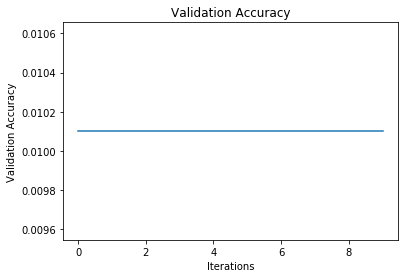

In [14]:
plt.plot(img_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

### Using Features Only

In [9]:
# build keras model for Features only
feat_model = Sequential()
feat_model.add(Dense(512, input_dim=192, kernel_initializer='uniform', activation='relu'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(256, activation='sigmoid'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(99, activation='softmax'))

feat_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [10]:
# output the model summary
feat_model.count_params()
feat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 99)                25443     
Total params: 255,587
Trainable params: 255,587
Non-trainable params: 0
_________________________________________________________________


In [11]:
feat_history = feat_model.fit(feat_train, train_labels_cat,
                              batch_size=16,
                              epochs=50,
                              validation_split=0.1,
                              shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/50
891/891 [==============================] - 0s - loss: 4.2485 - acc: 0.1212 - val_loss: 3.5602 - val_acc: 0.4343
Epoch 2/50
891/891 [==============================] - 0s - loss: 2.9782 - acc: 0.4400 - val_loss: 2.4803 - val_acc: 0.7071
Epoch 3/50
891/891 [==============================] - 0s - loss: 1.9165 - acc: 0.7026 - val_loss: 1.5127 - val_acc: 0.8788
Epoch 4/50
891/891 [==============================] - 0s - loss: 1.1958 - acc: 0.8429 - val_loss: 0.9104 - val_acc: 0.9596
Epoch 5/50
891/891 [==============================] - 0s - loss: 0.7380 - acc: 0.9181 - val_loss: 0.5483 - val_acc: 0.9394
Epoch 6/50
891/891 [==============================] - 0s - loss: 0.4784 - acc: 0.9540 - val_loss: 0.3513 - val_acc: 0.9697
Epoch 7/50
891/891 [==============================] - 0s - loss: 0.3196 - acc: 0.9652 - val_loss: 0.2631 - val_acc: 0.9697
Epoch 8/50
891/891 [==============================] - 0s - loss: 0.2093 - acc: 0.9798 - val_lo

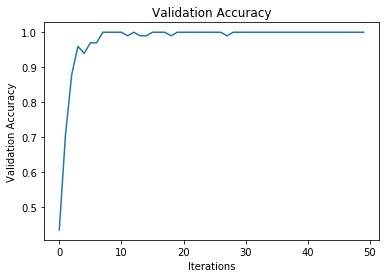

In [19]:
plt.plot(feat_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [25]:
# do prediction
pred = feat_model.predict_proba(feat_test)
columns = sorted(train.species.unique())
pred = pandas.DataFrame(pred, index=test.id, columns=columns)
output = open('prediction_fully_connected.csv','w')
output.write(pred.to_csv())
output.close()

 32/594 [>.............................] - ETA: 0s